<a href="https://colab.research.google.com/github/BabasTre/UTS-MachineLearning/blob/main/UTS_MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import os, math, json, joblib, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Direktori output
os.makedirs("data", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("reports/figs", exist_ok=True)

1. Data Preparation & EDA

In [4]:
# 1A. Generate data
n = 500
luas_tanah = np.random.uniform(50, 400, n)           # m2
luas_bangunan = np.random.uniform(30, 300, n)        # m2
kamar_tidur = np.random.randint(1, 7, n)             # unit
umur_bangunan = np.random.uniform(0, 40, n)          # tahun
jarak_pusat_kota = np.random.uniform(0.5, 25, n)     # km

# Hubungan non-linear realistis (target: harga dalam juta Rupiah)
base = 200     + 1.5 * np.sqrt(luas_bangunan) * 10     + 0.8 * np.sqrt(luas_tanah) * 8     + 25 * kamar_tidur     - 2.2 * np.log1p(jarak_pusat_kota) * 15     - 1.1 * umur_bangunan

interaction = 0.02 * (luas_bangunan * kamar_tidur) ** 0.5
curvature = 0.0008 * (luas_bangunan ** 2) / 100.0
noise = np.random.normal(0, 20, n)

harga = base + interaction + curvature + noise
harga = np.clip(harga, 50, None)

df = pd.DataFrame({
    "luas_tanah": luas_tanah,
    "luas_bangunan": luas_bangunan,
    "kamar_tidur": kamar_tidur,
    "umur_bangunan": umur_bangunan,
    "jarak_pusat_kota": jarak_pusat_kota,
    "harga": harga
})
df.to_csv("data/dataset_properti.csv", index=False)

In [26]:
#1B) EDA
# Pastikan kolom target
target_col = 'harga'
assert target_col in df.columns, f"Kolom target '{target_col}' tidak ditemukan."

# Pilih kolom numerik
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

In [27]:
# 1) Statistical summary
print("=== Statistical Summary ===")
display(df[num_cols].describe().T)

=== Statistical Summary ===


,count,mean,std,min,25%,50%,75%,max
luas_tanah,500.0,224.496599,104.540943,51.771554,134.447892,229.607312,314.643709,397.537679
luas_bangunan,500.0,160.126876,77.083233,31.250646,91.856797,157.391823,226.110941,299.923772
kamar_tidur,500.0,3.502000,1.714607,1.000000,2.000000,3.000000,5.000000,6.000000
umur_bangunan,500.0,19.986726,11.624441,0.197599,9.550844,20.267533,29.479783,39.976549
jarak_pusat_kota,500.0,12.869517,7.012953,0.538345,6.830002,13.108194,18.978682,24.959514
harga,500.0,460.910163,76.387675,258.606586,412.281149,458.672070,513.602955,685.174242


Histogram per Fitur


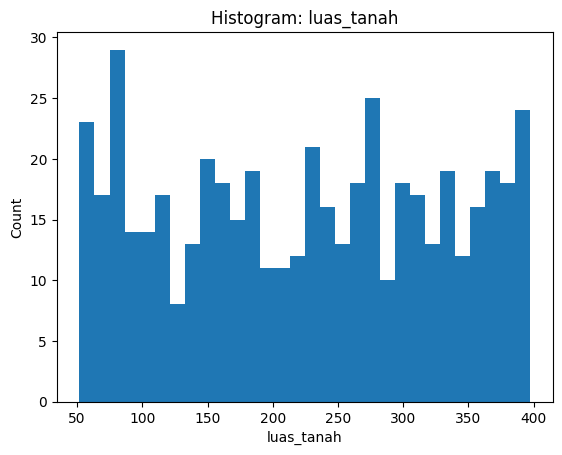

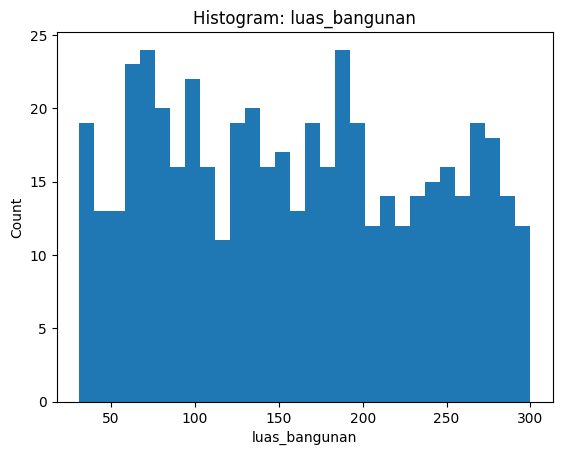

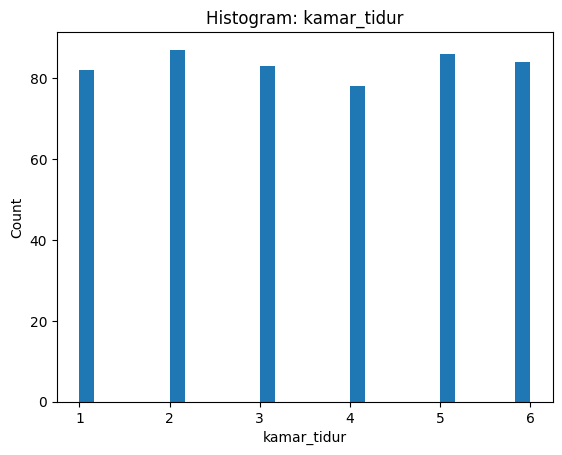

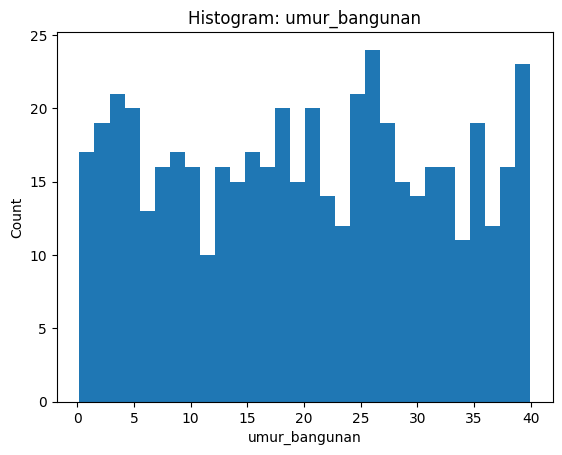

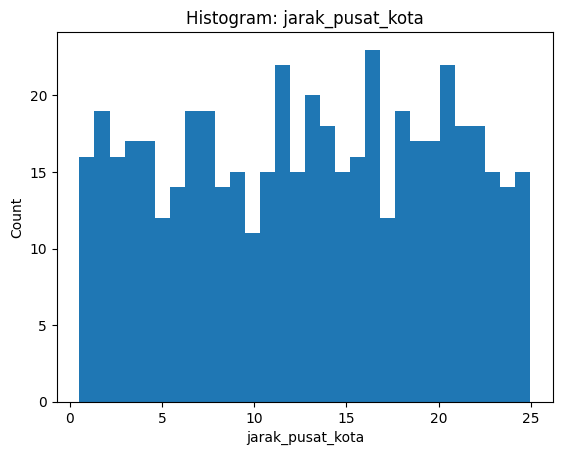

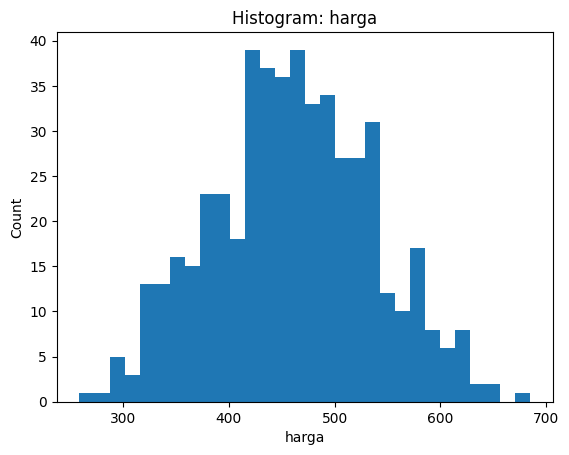

In [30]:
# 2) Histogram
print("Histogram per Fitur")
for col in num_cols:
    plt.figure()
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

Scatter Plot: Fitur vs harga


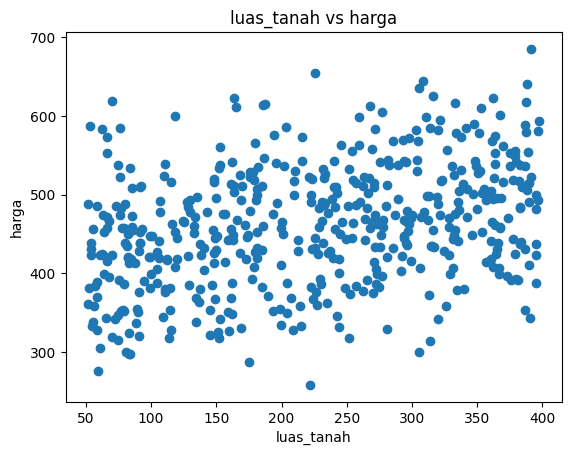

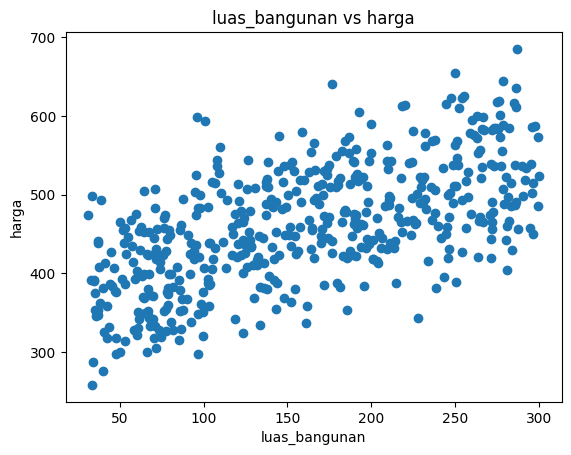

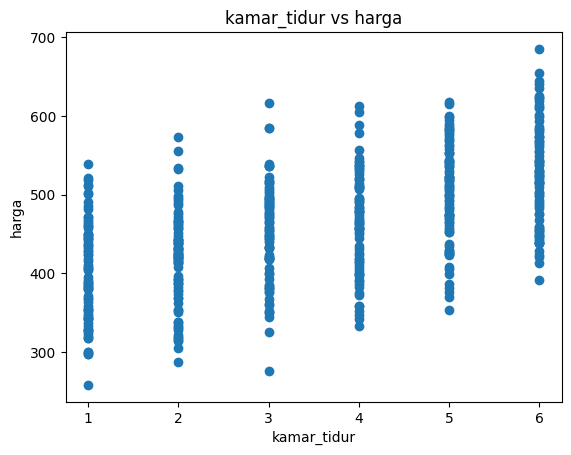

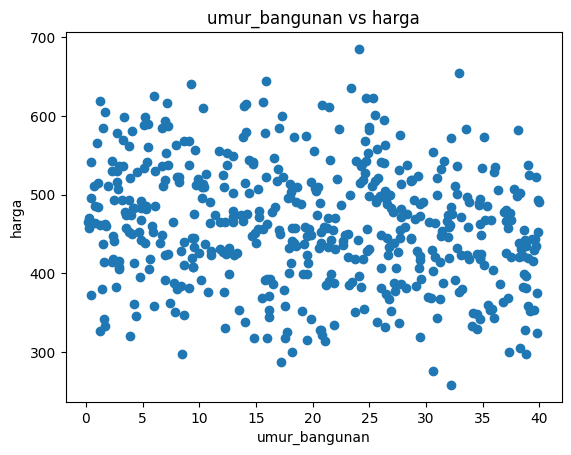

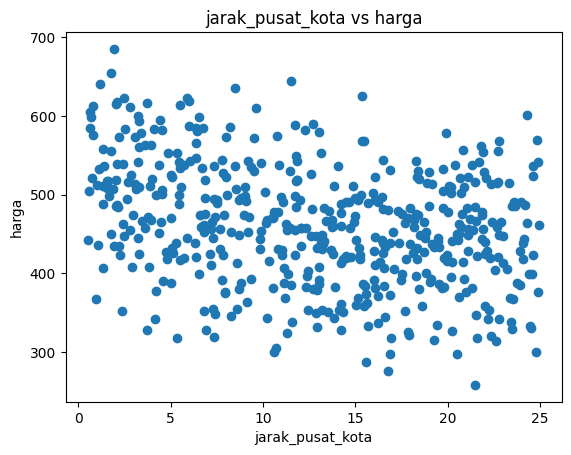

In [31]:
# 3) Scatter plot
print("Scatter Plot: Fitur vs harga")
feature_cols = [c for c in num_cols if c != target_col]
for col in feature_cols:
    plt.figure()
    plt.scatter(df[col], df[target_col])
    plt.xlabel(col)
    plt.ylabel(target_col)
    plt.title(f"{col} vs {target_col}")
    plt.show()

Correlation Matrix (Heatmap)


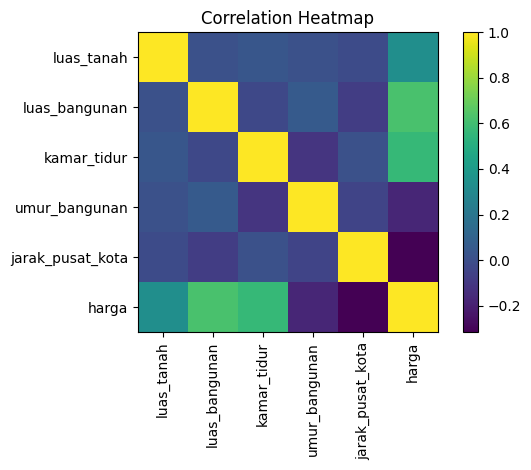

In [32]:
# 4) Correlation matrix (heatmap)
print("Correlation Matrix (Heatmap)")
corr = df[num_cols].corr(numeric_only=True)
plt.figure()
im = plt.imshow(corr, interpolation="nearest")
plt.title("Correlation Heatmap")
plt.colorbar(im)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.tight_layout()
plt.show()

In [34]:
# 5) Identifikasi outliers (IQR) per kolom numerik
print("Deteksi Outliers (IQR) per Kolom")
outlier_flags = pd.DataFrame(index=df.index)
for col in num_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    flag = (df[col] < lower) | (df[col] > upper)
    outlier_flags[col] = flag
    print(f"{col:>20} | Q1={q1:.3f} Q3={q3:.3f} IQR={iqr:.3f}  -> outliers: {int(flag.sum())}")

# Baris yang merupakan outlier pada minimal satu kolom
any_outlier_rows = outlier_flags.any(axis=1)
n_any = int(any_outlier_rows.sum())
print(f"\nTotal baris dengan minimal satu outlier: {n_any} dari {len(df)}")
if n_any > 0:
    display(df.loc[any_outlier_rows].head(10))  # tampilkan sampel outlier

Deteksi Outliers (IQR) per Kolom
          luas_tanah | Q1=134.448 Q3=314.644 IQR=180.196  -> outliers: 0
       luas_bangunan | Q1=91.857 Q3=226.111 IQR=134.254  -> outliers: 0
         kamar_tidur | Q1=2.000 Q3=5.000 IQR=3.000  -> outliers: 0
       umur_bangunan | Q1=9.551 Q3=29.480 IQR=19.929  -> outliers: 0
    jarak_pusat_kota | Q1=6.830 Q3=18.979 IQR=12.149  -> outliers: 0
               harga | Q1=412.281 Q3=513.603 IQR=101.322  -> outliers: 2

Total baris dengan minimal satu outlier: 2 dari 500


,luas_tanah,luas_bangunan,kamar_tidur,umur_bangunan,jarak_pusat_kota,harga
340,222.065556,33.535503,1,32.237016,21.465563,258.606586
498,391.038183,286.564086,6,24.075264,1.958355,685.174242


In [35]:
# 1C) Data Preprocessing
# 1) Split 70:30
target = 'harga'
assert target in df.columns
feature_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != target]
X_df = df[feature_cols].copy()
y = df[target].values

X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_df, y, test_size=0.30, random_state=42
)
print("Shapes (awal) ->", "X_train:", X_train_df.shape, "| X_test:", X_test_df.shape)

Shapes (awal) -> X_train: (350, 5) | X_test: (150, 5)


In [36]:
# 2) Feature scaling
USE_SCALER = "standard"
scaler = StandardScaler() if USE_SCALER == "standard" else None

X_train_scaled = scaler.fit_transform(X_train_df.values)
X_test_scaled  = scaler.transform(X_test_df.values)

print("Contoh 5 baris fitur hasil scaling (train):")
print(pd.DataFrame(X_train_scaled, columns=feature_cols).head())

Contoh 5 baris fitur hasil scaling (train):
   luas_tanah  luas_bangunan  kamar_tidur  umur_bangunan  jarak_pusat_kota
0   -1.176599      -1.140268     0.899217      -1.474047          1.463334
1    0.994669      -1.494081     0.312042       0.696880         -0.264446
2    0.521479      -0.458887     0.899217      -0.454274         -0.741695
3   -0.679615      -0.395119    -0.862309      -1.588053          0.476205
4    0.801480      -0.851987     1.486393      -1.429304         -1.755443


In [38]:
# 3) Handle missing
MISSING_STRATEGY = "median"

median_train = None
if MISSING_STRATEGY == "drop":
    m_train = ~X_train_df.isna().any(axis=1)
    X_train_df, y_train = X_train_df.loc[m_train], y_train[m_train.values]

    m_test = ~X_test_df.isna().any(axis=1)
    X_test_df, y_test = X_test_df.loc[m_test], y_test[m_test.values]

elif MISSING_STRATEGY == "median":
    median_train = X_train_df.median(numeric_only=True)
    X_train_df = X_train_df.fillna(median_train)
    X_test_df  = X_test_df.fillna(median_train)
else:
    raise ValueError("MISSING_STRATEGY harus 'drop' atau 'median'.")

print("Shapes (setelah missing) ->", "X_train:", X_train_df.shape, "| X_test:", X_test_df.shape)

Shapes (setelah missing) -> X_train: (350, 5) | X_test: (150, 5)


In [42]:
# 4) Simpan scaler
with open('property_price_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

print("Scaler disimpan ke 'property_price_scaler.pkl'")
print("\nData preprocessing selesai")
print(f"Siap untuk modeling dengan {len(X_train)} sampel training")

Scaler disimpan ke 'property_price_scaler.pkl'

Data preprocessing selesai
Siap untuk modeling dengan 350 sampel training


2. Model Implementation

In [14]:
#2A) Polynomial Feature Engineering
assert "harga" in df.columns
X = df.drop(columns=["harga"]).values
y = df["harga"].values

# split 70:30 (hanya untuk konsisten dengan tahap berikut)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE
)

def n_poly_features(n_input, degree):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    return poly.fit_transform(np.zeros((1, n_input))).shape[1]

# tabel jumlah fitur per degree
n_input = X_train.shape[1]
rows = []
for d in [1,2,3,4,5]:
    rows.append({"Degree": d, "Input_Features": n_input, "Output_Features": n_poly_features(n_input, d)})
pd.DataFrame(rows)

,Degree,Input_Features,Output_Features
0,1,5,5
1,2,5,20
2,3,5,55
3,4,5,125
4,5,5,251


In [15]:
#2B) Model Training
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    den = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / den))

def metrics_dict(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE": mape(y_true, y_pred),
    }

def n_poly_features(n_input, degree):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    return poly.fit_transform(np.zeros((1, n_input))).shape[1]

degrees = [1,2,3,4,5]
ridge_alphas = [0.1, 1, 10]
lasso_alphas = [0.1, 1, 10]

results, models = [], {}
n_input = X_train.shape[1]

for d in degrees:
    feats = n_poly_features(n_input, d)

    # Linear
    pipe = Pipeline([
        ("poly", PolynomialFeatures(degree=d, include_bias=False)),
        ("scaler", StandardScaler()),
        ("reg", LinearRegression())
    ])
    pipe.fit(X_train, y_train)
    ytr, yte = pipe.predict(X_train), pipe.predict(X_test)
    mtr, mte = metrics_dict(y_train, ytr), metrics_dict(y_test, yte)
    name = f"Linear_deg{d}"
    models[name] = pipe
    results.append({"Model": name, "Degree": d, "Features": feats,
                    "Train_R2": mtr["R2"], "Test_R2": mte["R2"],
                    "Train_RMSE": mtr["RMSE"], "Test_RMSE": mte["RMSE"],
                    "Train_MAE": mtr["MAE"], "Test_MAE": mte["MAE"],
                    "Train_MAPE": mtr["MAPE"], "Test_MAPE": mte["MAPE"]})

    # Ridge
    for a in ridge_alphas:
        pipe = Pipeline([
            ("poly", PolynomialFeatures(degree=d, include_bias=False)),
            ("scaler", StandardScaler()),
            ("reg", Ridge(alpha=a, random_state=RANDOM_STATE))
        ])
        pipe.fit(X_train, y_train)
        ytr, yte = pipe.predict(X_train), pipe.predict(X_test)
        mtr, mte = metrics_dict(y_train, ytr), metrics_dict(y_test, yte)
        name = f"Ridge_deg{d}_a{a}"
        models[name] = pipe
        results.append({"Model": name, "Degree": d, "Features": feats,
                        "Train_R2": mtr["R2"], "Test_R2": mte["R2"],
                        "Train_RMSE": mtr["RMSE"], "Test_RMSE": mte["RMSE"],
                        "Train_MAE": mtr["MAE"], "Test_MAE": mte["MAE"],
                        "Train_MAPE": mtr["MAPE"], "Test_MAPE": mte["MAPE"]})

    # Lasso
    for a in lasso_alphas:
        pipe = Pipeline([
            ("poly", PolynomialFeatures(degree=d, include_bias=False)),
            ("scaler", StandardScaler()),
            ("reg", Lasso(alpha=a, random_state=RANDOM_STATE, max_iter=20000))
        ])
        pipe.fit(X_train, y_train)
        ytr, yte = pipe.predict(X_train), pipe.predict(X_test)
        mtr, mte = metrics_dict(y_train, ytr), metrics_dict(y_test, yte)
        name = f"Lasso_deg{d}_a{a}"
        models[name] = pipe
        results.append({"Model": name, "Degree": d, "Features": feats,
                        "Train_R2": mtr["R2"], "Test_R2": mte["R2"],
                        "Train_RMSE": mtr["RMSE"], "Test_RMSE": mte["RMSE"],
                        "Train_MAE": mtr["MAE"], "Test_MAE": mte["MAE"],
                        "Train_MAPE": mtr["MAPE"], "Test_MAPE": mte["MAPE"]})

results_df = pd.DataFrame(results).sort_values(by=["Test_R2","Train_R2"], ascending=False)
display(results_df.head(15))
best_name = results_df.iloc[0]["Model"]
print("Best model by Test_R2:", best_name)

,Model,Degree,Features,Train_R2,Test_R2,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_MAPE,Test_MAPE
7,Linear_deg2,2,20,0.930389,0.929700,19.719731,21.164041,15.850579,16.667767,0.034959,0.037146
8,Ridge_deg2_a0.1,2,20,0.930379,0.929627,19.721112,21.175041,15.866244,16.669091,0.035006,0.037150
11,Lasso_deg2_a0.1,2,20,0.929689,0.929545,19.818722,21.187250,16.011630,16.654574,0.035416,0.037155
9,Ridge_deg2_a1,2,20,0.929681,0.928390,19.819796,21.360314,16.059117,16.750459,0.035541,0.037336
18,Lasso_deg3_a0.1,3,55,0.930838,0.928269,19.656054,21.378301,15.793096,17.059478,0.034897,0.038132
25,Lasso_deg4_a0.1,4,125,0.931860,0.926872,19.510243,21.585424,15.559479,17.186972,0.034386,0.038438
32,Lasso_deg5_a0.1,5,251,0.934000,0.924597,19.201497,21.918727,15.239036,17.523148,0.033679,0.039162
0,Linear_deg1,1,5,0.915064,0.923665,21.782592,22.053713,17.509688,17.268014,0.038912,0.038723
1,Ridge_deg1_a0.1,1,5,0.915064,0.923652,21.782602,22.055535,17.511262,17.269125,0.038917,0.038727
2,Ridge_deg1_a1,1,5,0.915056,0.923533,21.783549,22.072820,17.526130,17.280251,0.038960,0.038766


Best model by Test_R2: Linear_deg2


In [16]:
#2C) Custom Implementation
# pilih degree terbaik dari results_df (atau set manual)
best_degree = int(results_df.iloc[0]["Degree"])

# bangun fitur polinomial + scaling (tanpa LinearRegression)
poly = PolynomialFeatures(degree=best_degree, include_bias=False)
Xtr_poly = poly.fit_transform(X_train)
Xte_poly = poly.transform(X_test)

scaler = StandardScaler()
Xtr_std = scaler.fit_transform(Xtr_poly)
Xte_std = scaler.transform(Xte_poly)

# tambahkan bias secara manual
Xtr_bias = np.c_[np.ones((Xtr_std.shape[0], 1)), Xtr_std]
Xte_bias = np.c_[np.ones((Xte_std.shape[0], 1)), Xte_std]

# normal equation: theta = (X^T X)^(-1) X^T y  (pakai pinv biar aman)
theta = np.linalg.pinv(Xtr_bias.T @ Xtr_bias) @ Xtr_bias.T @ y_train

# prediksi
ytr_hat = Xtr_bias @ theta
yte_hat = Xte_bias @ theta

# metrik
mtr = metrics_dict(y_train, ytr_hat)
mte = metrics_dict(y_test,  yte_hat)

print(f"Custom Poly (degree={best_degree}) — Normal Equation")
print(" Train -> R2: %.4f | RMSE: %.4f | MAE: %.4f" % (mtr["R2"], mtr["RMSE"], mtr["MAE"]))
print(" Test  -> R2: %.4f | RMSE: %.4f | MAE: %.4f" % (mte["R2"], mte["RMSE"], mte["MAE"]))

Custom Poly (degree=2) — Normal Equation
 Train -> R2: 0.9304 | RMSE: 19.7197 | MAE: 15.8506
 Test  -> R2: 0.9297 | RMSE: 21.1640 | MAE: 16.6678


3. Model Evaluation

In [18]:
#3A) Metrics Calculation
print("=== Top 10 models by Test_R2 ===")
display(results_df.head(10))

# Ringkas 'best per degree' (model dengan Test_R2 tertinggi untuk tiap degree)
best_per_degree = (results_df
                   .sort_values(["Degree","Test_R2","Train_R2"], ascending=[True, False, False])
                   .groupby("Degree", as_index=False).first())

print("\n=== Best per degree (Train/Test metrics) ===")
display(best_per_degree[[
    "Degree","Model","Features",
    "Train_R2","Test_R2","Train_RMSE","Test_RMSE",
    "Train_MAE","Test_MAE","Train_MAPE","Test_MAPE"
]])

# Simpan untuk dipakai di bagian B & C
best_name = results_df.iloc[0]["Model"]
best_model = models[best_name]
print("\nBest model overall:", best_name)

=== Top 10 models by Test_R2 ===


,Model,Degree,Features,Train_R2,Test_R2,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_MAPE,Test_MAPE
7,Linear_deg2,2,20,0.930389,0.929700,19.719731,21.164041,15.850579,16.667767,0.034959,0.037146
8,Ridge_deg2_a0.1,2,20,0.930379,0.929627,19.721112,21.175041,15.866244,16.669091,0.035006,0.037150
11,Lasso_deg2_a0.1,2,20,0.929689,0.929545,19.818722,21.187250,16.011630,16.654574,0.035416,0.037155
9,Ridge_deg2_a1,2,20,0.929681,0.928390,19.819796,21.360314,16.059117,16.750459,0.035541,0.037336
18,Lasso_deg3_a0.1,3,55,0.930838,0.928269,19.656054,21.378301,15.793096,17.059478,0.034897,0.038132
25,Lasso_deg4_a0.1,4,125,0.931860,0.926872,19.510243,21.585424,15.559479,17.186972,0.034386,0.038438
32,Lasso_deg5_a0.1,5,251,0.934000,0.924597,19.201497,21.918727,15.239036,17.523148,0.033679,0.039162
0,Linear_deg1,1,5,0.915064,0.923665,21.782592,22.053713,17.509688,17.268014,0.038912,0.038723
1,Ridge_deg1_a0.1,1,5,0.915064,0.923652,21.782602,22.055535,17.511262,17.269125,0.038917,0.038727
2,Ridge_deg1_a1,1,5,0.915056,0.923533,21.783549,22.072820,17.526130,17.280251,0.038960,0.038766



=== Best per degree (Train/Test metrics) ===


,Degree,Model,Features,Train_R2,Test_R2,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE,Train_MAPE,Test_MAPE
0,1,Linear_deg1,5,0.915064,0.923665,21.782592,22.053713,17.509688,17.268014,0.038912,0.038723
1,2,Linear_deg2,20,0.930389,0.929700,19.719731,21.164041,15.850579,16.667767,0.034959,0.037146
2,3,Lasso_deg3_a0.1,55,0.930838,0.928269,19.656054,21.378301,15.793096,17.059478,0.034897,0.038132
3,4,Lasso_deg4_a0.1,125,0.931860,0.926872,19.510243,21.585424,15.559479,17.186972,0.034386,0.038438
4,5,Lasso_deg5_a0.1,251,0.934000,0.924597,19.201497,21.918727,15.239036,17.523148,0.033679,0.039162



Best model overall: Linear_deg2


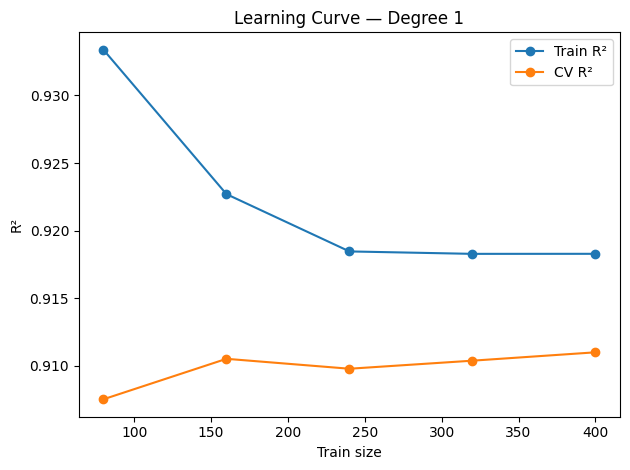

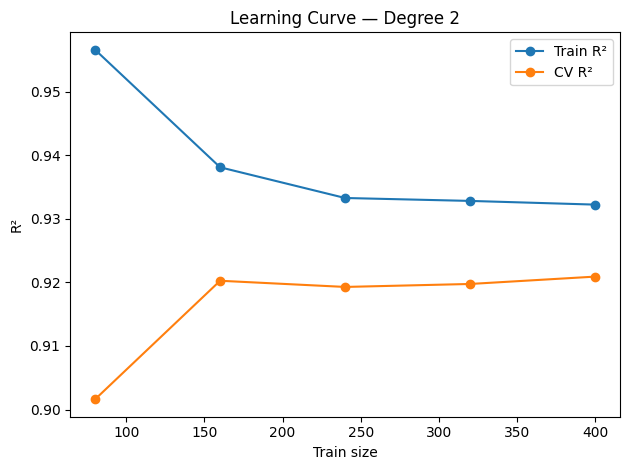

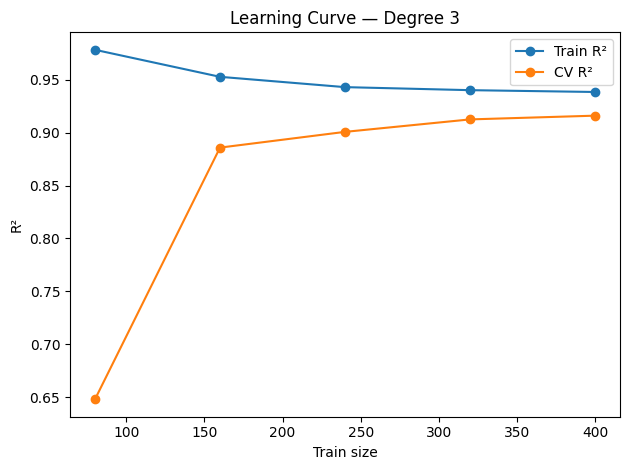

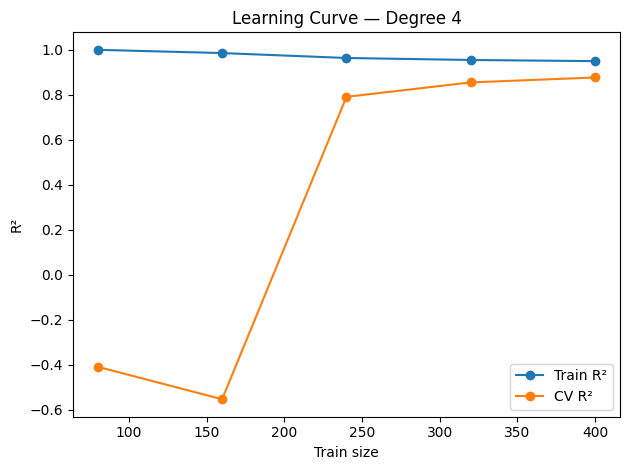

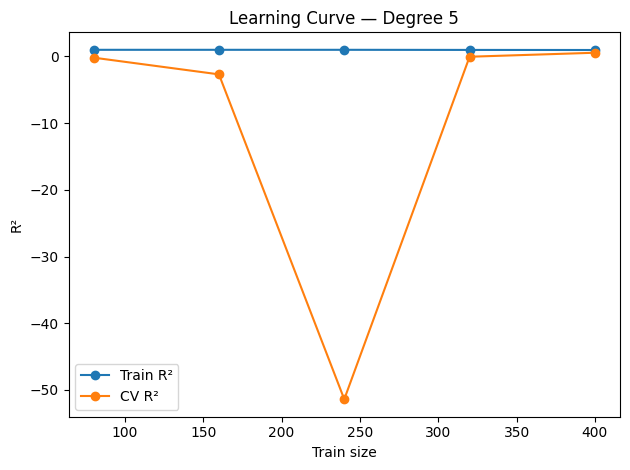


=== Diagnosis per Degree ===


,Degree,Model,Train_R2,Test_R2,Gap,Diagnosis
0,1,Linear_deg1,0.915064,0.923665,-0.008601,Optimal / Balanced
1,2,Linear_deg2,0.930389,0.929700,0.000690,Optimal / Balanced
2,3,Lasso_deg3_a0.1,0.930838,0.928269,0.002569,Optimal / Balanced
3,4,Lasso_deg4_a0.1,0.931860,0.926872,0.004988,Optimal / Balanced
4,5,Lasso_deg5_a0.1,0.934000,0.924597,0.009403,Optimal / Balanced



Analisis bias–variance (singkat):
- Degree 1: Test R²=0.924, gap=-0.009 → Optimal / Balanced
- Degree 2: Test R²=0.930, gap=0.001 → Optimal / Balanced
- Degree 3: Test R²=0.928, gap=0.003 → Optimal / Balanced
- Degree 4: Test R²=0.927, gap=0.005 → Optimal / Balanced
- Degree 5: Test R²=0.925, gap=0.009 → Optimal / Balanced


In [19]:
#3B) Overfitting & Underfitting Analysis
# 1) Learning curves untuk setiap degree
degrees = sorted(results_df["Degree"].unique().tolist())
X_all = np.vstack([X_train, X_test])
y_all = np.hstack([y_train, y_test])

for d in degrees:
    pipe = Pipeline([
        ("poly", PolynomialFeatures(degree=d, include_bias=False)),
        ("scaler", StandardScaler()),
        ("reg", LinearRegression())
    ])
    sizes, tr_scores, te_scores = learning_curve(
        pipe, X_all, y_all, cv=5, scoring="r2",
        train_sizes=np.linspace(0.2, 1.0, 5),
        shuffle=True, random_state=42   # penting agar random_state dipakai
    )
    plt.figure()
    plt.plot(sizes, tr_scores.mean(axis=1), marker="o", label="Train R²")
    plt.plot(sizes, te_scores.mean(axis=1), marker="o", label="CV R²")
    plt.xlabel("Train size"); plt.ylabel("R²")
    plt.title(f"Learning Curve — Degree {d}")
    plt.legend(); plt.tight_layout(); plt.show()

# 2) Bandingkan Train vs Test score & klasifikasi sederhana
def classify_row(train_r2, test_r2, gap_thresh=0.15, low_thresh=0.50):
    gap = train_r2 - test_r2
    if (train_r2 < low_thresh) and (test_r2 < low_thresh):
        return "Underfitting (bias tinggi)"
    if gap > gap_thresh and test_r2 < train_r2:
        return "Overfitting (variance tinggi)"
    return "Optimal / Balanced"

best_per_degree["Gap"] = best_per_degree["Train_R2"] - best_per_degree["Test_R2"]
best_per_degree["Diagnosis"] = best_per_degree.apply(
    lambda r: classify_row(r["Train_R2"], r["Test_R2"]), axis=1
)

print("\n=== Diagnosis per Degree ===")
display(best_per_degree[["Degree","Model","Train_R2","Test_R2","Gap","Diagnosis"]])

print("\nAnalisis bias–variance (singkat):")
for _, r in best_per_degree.iterrows():
    print(f"- Degree {int(r['Degree'])}: Test R²={r['Test_R2']:.3f}, gap={r['Gap']:.3f} → {r['Diagnosis']}")

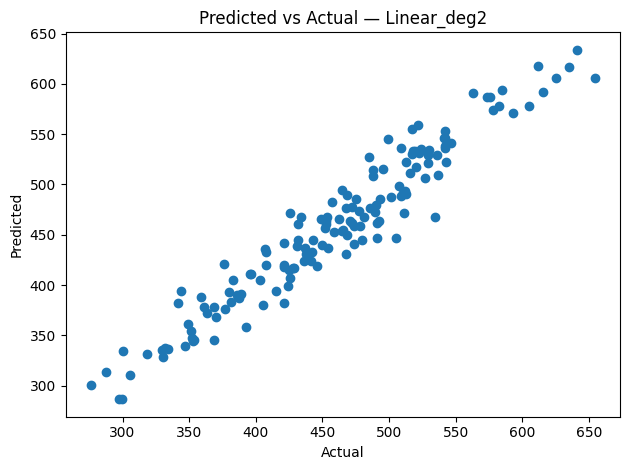

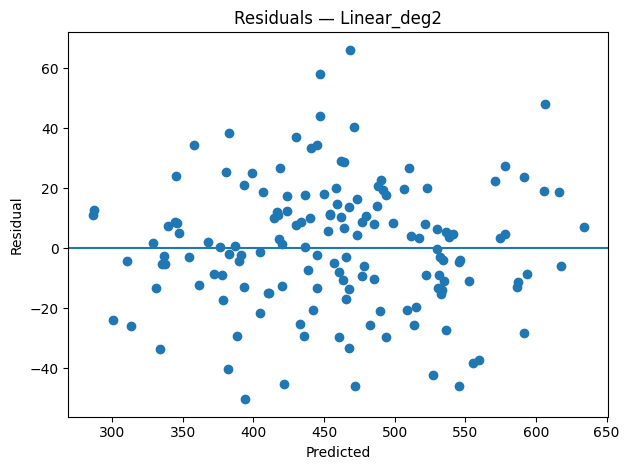

Fitur paling berpengaruh (|corr| tertinggi): ['luas_bangunan', 'kamar_tidur']


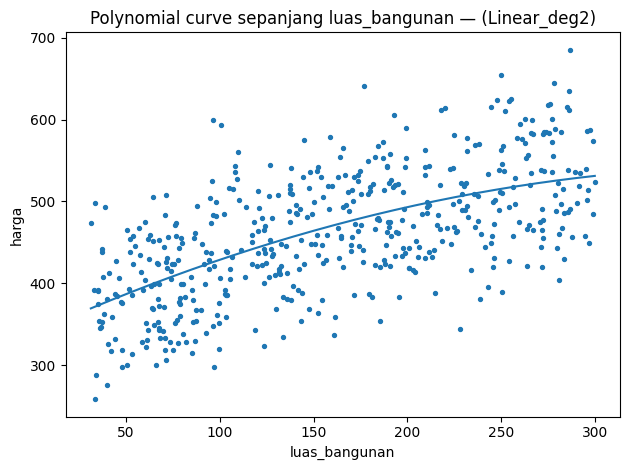

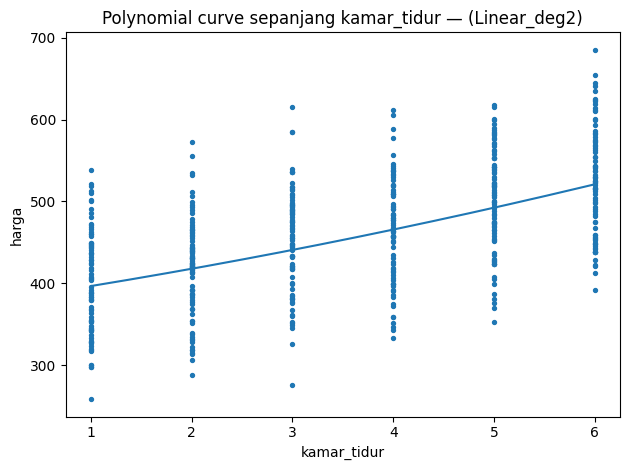

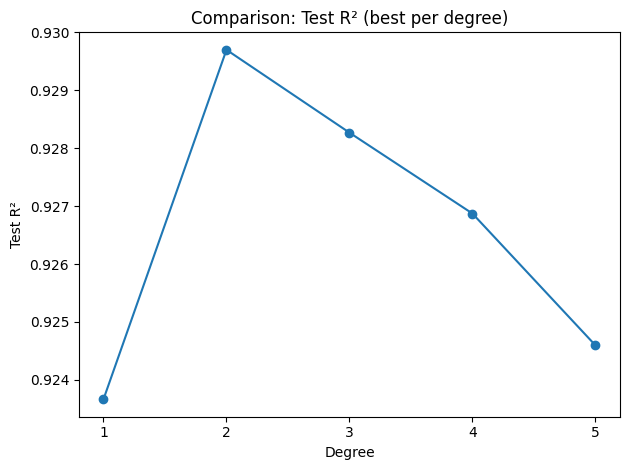

In [20]:
#3C) Visualization
# 1) Predicted vs Actual (test) + Residual plot
def plot_residuals(y_true, y_pred, title):
    plt.figure()
    resid = y_true - y_pred
    plt.scatter(y_pred, resid)
    plt.axhline(0)
    plt.xlabel("Predicted"); plt.ylabel("Residual")
    plt.title(title); plt.tight_layout(); plt.show()

y_pred_test = best_model.predict(X_test)

plt.figure()
plt.scatter(y_test, y_pred_test)
plt.xlabel("Actual"); plt.ylabel("Predicted")
plt.title(f"Predicted vs Actual — {best_name}")
plt.tight_layout(); plt.show()

plot_residuals(y_test, y_pred_test, title=f"Residuals — {best_name}")

# 2) Polynomial curve untuk 1–2 fitur paling berpengaruh (berdasarkan |corr| dengan target)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove("harga")
corr = df[num_cols + ["harga"]].corr(numeric_only=True)["harga"].drop("harga").abs().sort_values(ascending=False)
top_feats = corr.index.tolist()[:2]
print("Fitur paling berpengaruh (|corr| tertinggi):", list(top_feats))

def plot_poly_curve_for_feature(feature_name, n_points=200):
    feat_idx = df.columns.drop("harga").get_loc(feature_name)
    X_ref = np.median(X_test, axis=0)  # titik referensi
    xs = np.linspace(df[feature_name].min(), df[feature_name].max(), n_points)

    X_sweep = np.tile(X_ref, (n_points, 1))
    X_sweep[:, feat_idx] = xs
    ys = best_model.predict(X_sweep)

    plt.figure()
    plt.scatter(df[feature_name], df["harga"], s=8)
    plt.plot(xs, ys)
    plt.xlabel(feature_name); plt.ylabel("harga")
    plt.title(f"Polynomial curve sepanjang {feature_name} — ({best_name})")
    plt.tight_layout(); plt.show()

for f in top_feats:
    plot_poly_curve_for_feature(f)

# 3) Comparison plot: Test R² terbaik per degree
plt.figure()
plt.plot(best_per_degree["Degree"], best_per_degree["Test_R2"], marker="o")
plt.xlabel("Degree"); plt.ylabel("Test R²")
plt.title("Comparison: Test R² (best per degree)")
plt.xticks(best_per_degree["Degree"])
plt.tight_layout(); plt.show()

4. Regularization Analysis

Best degree (from Soal 2): 2


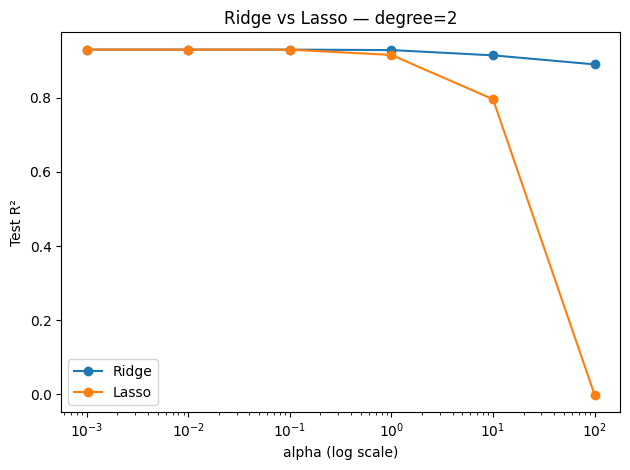

Ridge best (by Test R²): alpha = 0.001 , R² = 0.9296990602237196
Lasso best (by Test R²): alpha = 0.001 , R² = 0.9296978975695837


In [22]:
#4A) Ridge vs Lasso Comparison
# degree terbaik berdasar Test_R2 dari results_df
best_degree = int(results_df.iloc[0]["Degree"])
print("Best degree (from Soal 2):", best_degree)

# kandidat alpha (log grid)
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

def sweep(model_cls, alphas, degree):
    xs, ys = [], []
    for a in alphas:
        pipe = Pipeline([
            ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
            ("scaler", StandardScaler()),
            ("reg", model_cls(alpha=a, random_state=RANDOM_STATE) if model_cls is Lasso or model_cls is Ridge
                   else model_cls())
        ])
        pipe.fit(X_train, y_train)
        r2 = r2_score(y_test, pipe.predict(X_test))
        xs.append(a); ys.append(r2)
    return xs, ys

xs_ridge, ys_ridge = sweep(Ridge, alphas, best_degree)
xs_lasso, ys_lasso = sweep(Lasso, alphas, best_degree)

plt.figure()
plt.plot(xs_ridge, ys_ridge, marker="o", label="Ridge")
plt.plot(xs_lasso, ys_lasso, marker="o", label="Lasso")
plt.xscale("log")
plt.xlabel("alpha (log scale)"); plt.ylabel("Test R²")
plt.title(f"Ridge vs Lasso — degree={best_degree}")
plt.legend(); plt.tight_layout(); plt.show()

print("Ridge best (by Test R²): alpha =", alphas[int(np.argmax(ys_ridge))], ", R² =", max(ys_ridge))
print("Lasso best (by Test R²): alpha =", alphas[int(np.argmax(ys_lasso))], ", R² =", max(ys_lasso))

Best Ridge: alpha=0.001 | Test R²=0.9297
Best Lasso: alpha=0.001 | Test R²=0.9297


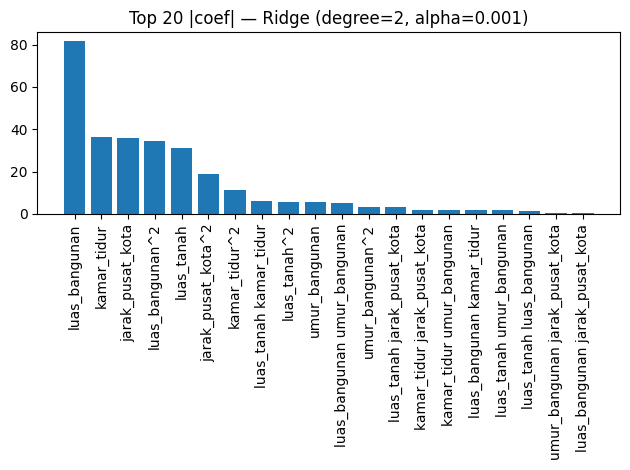

Lasso zeroed coefficients: 0 of 20

Contoh fitur yang dieliminasi (coef=0): []
Top 10 fitur penting versi Lasso (nama, coef):
         luas_bangunan  +81.6294
           kamar_tidur  +36.2833
      jarak_pusat_kota  -35.9672
       luas_bangunan^2  -34.2612
            luas_tanah  +31.2593
    jarak_pusat_kota^2  +18.9451
         kamar_tidur^2  +11.4245
  luas_tanah kamar_tidur  -5.8393
          luas_tanah^2  -5.7846
         umur_bangunan  -5.4494


In [23]:
#4A) Feature Importance Analysis
# nama fitur asli (kecuali target)
base_feature_names = df.drop(columns=["harga"]).columns.tolist()

def best_alpha_for(model_cls, alphas, degree):
    best_a, best_r2, best_pipe = None, -np.inf, None
    best_coefs, best_feature_names = None, None
    for a in alphas:
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        pipe = Pipeline([
            ("poly", poly),
            ("scaler", StandardScaler()),
            ("reg", model_cls(alpha=a, random_state=RANDOM_STATE) if model_cls is Lasso or model_cls is Ridge
                   else model_cls())
        ])
        pipe.fit(X_train, y_train)
        r2 = r2_score(y_test, pipe.predict(X_test))
        if r2 > best_r2:
            best_r2 = r2; best_a = a; best_pipe = pipe
            # nama fitur polinomial
            feat_names = poly.get_feature_names_out(base_feature_names).tolist()
            coefs = best_pipe.named_steps["reg"].coef_
            best_coefs, best_feature_names = coefs, feat_names
    return best_a, best_r2, best_pipe, best_coefs, best_feature_names

ridge_best_a, ridge_best_r2, ridge_pipe, ridge_coefs, poly_names = best_alpha_for(Ridge, [0.001,0.01,0.1,1,10,100], best_degree)
lasso_best_a, lasso_best_r2, lasso_pipe, lasso_coefs, _         = best_alpha_for(Lasso, [0.001,0.01,0.1,1,10,100], best_degree)

print(f"Best Ridge: alpha={ridge_best_a} | Test R²={ridge_best_r2:.4f}")
print(f"Best Lasso: alpha={lasso_best_a} | Test R²={lasso_best_r2:.4f}")

# --- Barplot Top-20 |coef| untuk Ridge ---
abs_coefs = np.abs(ridge_coefs)
order = np.argsort(-abs_coefs)[:20]
plt.figure()
plt.bar(range(len(order)), abs_coefs[order])
plt.xticks(range(len(order)), [poly_names[i] for i in order], rotation=90)
plt.title(f"Top 20 |coef| — Ridge (degree={best_degree}, alpha={ridge_best_a})")
plt.tight_layout(); plt.show()

# --- Fitur yang dieliminasi Lasso (coef ~ 0) ---
zero_mask = np.isclose(lasso_coefs, 0.0, atol=1e-8)
n_zero = int(zero_mask.sum())
print("Lasso zeroed coefficients:", n_zero, "of", len(lasso_coefs))

# tampilkan beberapa yang nol & yang terbesar
zero_features = [poly_names[i] for i, z in enumerate(zero_mask) if z]
nonzero_order = np.argsort(-np.abs(lasso_coefs))
top_nonzero = [(poly_names[i], float(lasso_coefs[i])) for i in nonzero_order[:10]]

print("\nContoh fitur yang dieliminasi (coef=0):", zero_features[:10])
print("Top 10 fitur penting versi Lasso (nama, coef):")
for nm, c in top_nonzero:
    print(f"  {nm:>20}  {c:+.4f}")

5. Model Selection & Prediction

In [24]:
#5A) Best Model Selection
# Kandidat: Top-N dari results_df berdasarkan Test_R2
topN = 5
candidates = results_df.head(topN)["Model"].tolist()

# K-Fold CV
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

rows = []
for name in candidates:
    pipe = models[name]                 # pipeline: poly -> scaler -> reg
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="r2")
    rows.append({
        "Model": name,
        "CV_R2_Mean": scores.mean(),
        "CV_R2_STD":  scores.std()
    })

cv_df = pd.DataFrame(rows).sort_values("CV_R2_Mean", ascending=False)
print("K-Fold R² (k=5) untuk kandidat teratas:")
display(cv_df)

# Strategi pemilihan akhir:
#   1) Prioritaskan Test_R2 tertinggi (results_df).
#   2) Jika selisih kecil, lihat CV_R2_Mean & stabilitas (STD kecil).
final_name = results_df.iloc[0]["Model"]        # boleh ganti ke cv_df.iloc[0]["Model"] jika ingin mengutamakan CV
final_model = models[final_name]

print("Model terpilih:", final_name)

K-Fold R² (k=5) untuk kandidat teratas:


,Model,CV_R2_Mean,CV_R2_STD
2,Lasso_deg2_a0.1,0.923362,0.009768
1,Ridge_deg2_a0.1,0.922648,0.010482
3,Ridge_deg2_a1,0.922634,0.009748
0,Linear_deg2,0.922584,0.010578
4,Lasso_deg3_a0.1,0.922328,0.010283


Model terpilih: Linear_deg2


In [25]:
#5A) Final Predictions
# Refit model TERPILIH di SELURUH DATA agar maksimal (opsi umum untuk produksi)
final_model.fit(X, y)

# Urutan kolom fitur sesuai data training
feature_cols = df.drop(columns=["harga"]).columns.tolist()

def predict_price(samples):
    """
    samples: list[dict] dengan key = nama fitur di 'feature_cols'
    return: np.array prediksi harga
    """
    X_new = pd.DataFrame(samples)[feature_cols].values
    return final_model.predict(X_new)

# 5 sampel baru (unseen)
samples = [
    {"luas_tanah": 120, "luas_bangunan": 80,  "kamar_tidur": 3, "umur_bangunan": 5,  "jarak_pusat_kota": 4},
    {"luas_tanah": 300, "luas_bangunan": 200, "kamar_tidur": 5, "umur_bangunan": 10, "jarak_pusat_kota": 8},
    {"luas_tanah":  90, "luas_bangunan": 60,  "kamar_tidur": 2, "umur_bangunan": 2,  "jarak_pusat_kota": 2},
    {"luas_tanah": 180, "luas_bangunan": 120, "kamar_tidur": 4, "umur_bangunan": 15, "jarak_pusat_kota": 12},
    {"luas_tanah": 220, "luas_bangunan": 150, "kamar_tidur": 4, "umur_bangunan": 25, "jarak_pusat_kota": 20},
]
preds = predict_price(samples)
pred_df = pd.DataFrame(samples)[feature_cols]
pred_df["pred_harga"] = preds
display(pred_df)

# (Opsional) Confidence Interval sederhana via bootstrap
def bootstrap_pred_interval(model, X_train, y_train, X_new, B=200, alpha=0.05, random_state=42):
    rng = np.random.RandomState(random_state)
    preds_boot = []
    n = len(X_train)
    for _ in range(B):
        idx = rng.randint(0, n, n)
        # clone pipeline dengan parameter yang sama
        clone = joblib.loads(joblib.dumps(model))
        clone.fit(X_train[idx], y_train[idx])
        preds_boot.append(clone.predict(X_new))
    preds_boot = np.vstack(preds_boot)          # (B, m)
    lower = np.percentile(preds_boot, 100*alpha/2, axis=0)
    upper = np.percentile(preds_boot, 100*(1-alpha/2), axis=0)
    return lower, upper

# hitung CI 95%
try:
    X_new = pd.DataFrame(samples)[feature_cols].values
    lower, upper = bootstrap_pred_interval(final_model, X, y, X_new, B=200, alpha=0.05)
    pred_df["ci_lower"], pred_df["ci_upper"] = lower, upper
    display(pred_df)
except Exception as e:
    print("Bootstrap CI dilewati (opsional):", e)

# Simpan pipeline final (sudah termasuk poly + scaler + regressor)
os.makedirs("models", exist_ok=True)
outpath = "models/final_model.pkl"
joblib.dump(final_model, outpath)
print("Saved model to:", os.path.abspath(outpath))

,luas_tanah,luas_bangunan,kamar_tidur,umur_bangunan,jarak_pusat_kota,pred_harga
0,120,80,3,5,4,417.229274
1,300,200,5,10,8,569.328648
2,90,60,2,2,2,380.208488
3,180,120,4,15,12,446.302373
4,220,150,4,25,20,447.949782


Bootstrap CI dilewati (opsional): module 'joblib' has no attribute 'loads'
Saved model to: /content/models/final_model.pkl
